**Topic Modelling**

**Importing Required Libraries**

In [1]:
import time
import math
import re
from textblob import TextBlob
import pandas as pd

import nltk as nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import string


import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
%pip install pyLDAvis
#import pyLDAvis.gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=cc7eb6f0cb439d27eb225416ef37f9844f06e44c7e46bdc63c6f486c15b94d7a
  Stored in directory: /root/.cache/pip/wheels/90/61/ec/9dbe9efc3acf9c4e37ba70fbbcc3f3a0ebd121060aa593181a
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=dfb15b815e34deb61169ed6740d41b6aba16e13e8df04b599291a6151382e1b0
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built pyLDAvis sklearn


/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable


In [2]:
import sklearn
import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs

In [4]:
input_file = codecs.open("socialmedia_relevant_cols.csv", "r",encoding='utf-8', errors='replace')
output_file = open("socialmedia_relevant_cols_clean.csv", "w")

def sanitize_characters(raw, clean):    
    for line in input_file:
        out = line
        output_file.write(line)
sanitize_characters(input_file, output_file)

In [5]:
df = pd.read_csv("socialmedia_relevant_cols_clean.csv")
df.columns=['text', 'choose_one', 'class_label']

In [11]:
df.head()

,text,choose_one,class_label
0,Just happened a terrible car crash,Relevant,1
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1
2,"Heard about #earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,Forest fire near La Ronge Sask. Canada,Relevant,1


In [6]:
df.shape

(10833, 3)

**Cleaning the text data**

In [7]:
df['text_clean'] = df['text'].map(lambda x: re.sub('[^a-zA-Z0-9 @ . , : - _ ]', '', str(x)))

In [8]:
df.head()

,text,choose_one,class_label,text_clean
0,Just happened a terrible car crash,Relevant,1,Just happened a terrible car crash
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1,Our Deeds are the Reason of this earthquake Ma...
2,"Heard about #earthquake is different cities, s...",Relevant,1,"Heard about earthquake is different cities, st..."
3,"there is a forest fire at spot pond, geese are...",Relevant,1,"there is a forest fire at spot pond, geese are..."
4,Forest fire near La Ronge Sask. Canada,Relevant,1,Forest fire near La Ronge Sask. Canada


In [9]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop = set(nltk.corpus.stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

df["text_clean"] = df["text_clean"].apply(clean)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [10]:
df.head()

,text,choose_one,class_label,text_clean
0,Just happened a terrible car crash,Relevant,1,happened terrible car crash
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1,deed reason earthquake may allah forgive u
2,"Heard about #earthquake is different cities, s...",Relevant,1,heard earthquake different city stay safe ever...
3,"there is a forest fire at spot pond, geese are...",Relevant,1,forest fire spot pond goose fleeing across str...
4,Forest fire near La Ronge Sask. Canada,Relevant,1,forest fire near la ronge sask canada


**Tokenizing the text data**

In [11]:
nltk.download('punkt')
df["clean_tokens"] = df["text_clean"].apply(lambda x: nltk.word_tokenize(x))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**Creating a term dictionary and document term matrix (First step of topic modelling)**

In [12]:
%%time
# Creating the term dictionary of our corpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(df["clean_tokens"])
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in df["clean_tokens"]]

CPU times: user 293 ms, sys: 7.58 ms, total: 301 ms
Wall time: 302 ms


**Creating a Latent Dirichlet Allocation(LDA) Model for topic modelling**

In [13]:
Lda = gensim.models.ldamodel.LdaModel

**Building initial 3 topic model**

In [14]:
import warnings
warnings.simplefilter('ignore')
%time ldamodel = Lda(doc_term_matrix, num_topics=3, id2word = dictionary, passes=50) #3 topics
print(*ldamodel.print_topics(num_topics=3, num_words=3), sep='\n')

CPU times: user 1min 47s, sys: 1.29 s, total: 1min 48s
Wall time: 1min 48s
(0, '0.007*"disaster" + 0.007*"video" + 0.005*"weapon"')
(1, '0.008*"like" + 0.007*"im" + 0.006*"get"')
(2, '0.014*"fire" + 0.005*"emergency" + 0.005*"suicide"')


**Visualizing the 3 topic model using pyLDAvis**

In [15]:
%%time

lda_display = gensimvis.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

CPU times: user 1.79 s, sys: 136 ms, total: 1.92 s
Wall time: 5.59 s


**Hyperparameter tuning the LDA model to find optimal number of topics for this data using coherence score**

In [16]:
start_time = time.time()

def tic():
    global start_time 
    start_time = time.time()

def tac():
    t_sec = round(time.time() - start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print(f'Execution time to calculate for topic {k}: {t_hour}hour:{t_min}min:{t_sec}sec'.format(t_hour,t_min,t_sec))

In [20]:
from gensim.models import CoherenceModel
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       num_topics=k,
                       random_state=100,                  
                       passes=10,
                       alpha=a,
                       eta=b,
                       #workers=workers
                       )
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=df["clean_tokens"], dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [21]:
import multiprocessing
num_processors = multiprocessing.cpu_count()
num_processors

workers = num_processors-2

print(f'Using {workers} workers')

Using 0 workers


In [22]:
%%time

grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics+1, step_size)

# Alpha parameter
# alpha = list(np.arange(0.01, 1, 0.3))
# alpha.append('symmetric')
# alpha.append('asymmetric')
alpha = ['asymmetric'] # Run for number of topics only

# Beta parameter
# beta = list(np.arange(0.01, 1, 0.3))
# beta.append('symmetric')
beta = ['auto'] # Run for number of topics only


# Validation sets
num_of_docs = len(doc_term_matrix)
corpus_sets = [# gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.5), 
#                gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.75), 
               doc_term_matrix]
# corpus_title = ['75% Corpus', '100% Corpus']
corpus_title = ['100% Corpus']
model_results = {
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

itr = 0
itr_total = len(beta)*len(alpha)*len(topics_range)*len(corpus_title)
print(f'LDA will execute {itr_total} iterations')

    
# iterate through hyperparameters
for i in range(len(corpus_sets)):
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        tic()
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                itr += 1
                cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                pct_completed = round((itr / itr_total * 100),1)
#                 print(f'Completed Percent: {pct_completed}%, Corpus: {corpus_title[i]}, Topics: {k}, Alpha: {a}, Beta: {b}, Coherence: {cv}')
        print(f'Completed model based on {k} LDA topics. Finished {pct_completed}% of LDA runs')
        tac()
                    
lda_tuning = pd.DataFrame(model_results)
lda_tuning.to_csv('lda_tuning_results.csv', index=False)

LDA will execute 9 iterations
Completed model based on 2 LDA topics. Finished 11.1% of LDA runs
Execution time to calculate for topic 2: 0hour:1min:15sec
Completed model based on 3 LDA topics. Finished 22.2% of LDA runs
Execution time to calculate for topic 3: 0hour:1min:6sec
Completed model based on 4 LDA topics. Finished 33.3% of LDA runs
Execution time to calculate for topic 4: 0hour:0min:59sec
Completed model based on 5 LDA topics. Finished 44.4% of LDA runs
Execution time to calculate for topic 5: 0hour:0min:54sec
Completed model based on 6 LDA topics. Finished 55.6% of LDA runs
Execution time to calculate for topic 6: 0hour:0min:52sec
Completed model based on 7 LDA topics. Finished 66.7% of LDA runs
Execution time to calculate for topic 7: 0hour:0min:53sec
Completed model based on 8 LDA topics. Finished 77.8% of LDA runs
Execution time to calculate for topic 8: 0hour:0min:50sec
Completed model based on 9 LDA topics. Finished 88.9% of LDA runs
Execution time to calculate for topic

In [23]:
lda_tuning = pd.DataFrame(model_results)
lda_tuning.to_csv('lda_tuning_results.csv', index=False)

In [24]:
import os 
lda_tuning = pd.read_csv('lda_tuning_results.csv')
lda_tuning.sort_values(by=['Coherence'], ascending=False).head(10)

,Topics,Alpha,Beta,Coherence
0,2,asymmetric,auto,0.490353
2,4,asymmetric,auto,0.411345
1,3,asymmetric,auto,0.402415
8,10,asymmetric,auto,0.396119
7,9,asymmetric,auto,0.394736
4,6,asymmetric,auto,0.393318
5,7,asymmetric,auto,0.381731
6,8,asymmetric,auto,0.363830
3,5,asymmetric,auto,0.350271


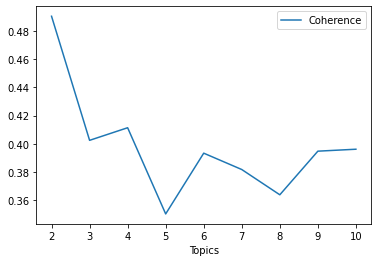

In [25]:
lda_tuning.plot(x ='Topics', y='Coherence', kind = 'line', xticks=range(2,11))

We can see that the coherence score of topic 2 is the highest followed by 4, 3 and 10. Since the coherence scores are very close to each other, we will run all the lda topic models and check if the topics make sense and if there is any overlap in pyLDAviz

In [26]:
lda_tuning_best = lda_tuning.sort_values(by=['Coherence'], ascending=False).head(1)


tuned_topics = int(lda_tuning_best['Topics'].to_string(index=False))


# Since the values for Alpha and Beta can be float, symmetric and asymmetric, we will either strip or convert to float
try:
    tuned_alpha = float(lda_tuning_best['Alpha'].to_string(index=False))
except:
    tuned_alpha = lda_tuning_best['Alpha'].to_string(index=False).strip()
    

try:
    tuned_beta = float(lda_tuning_best['Beta'].to_string(index=False))
except:
    tuned_beta = lda_tuning_best['Beta'].to_string(index=False).strip()    
    
print(f'Best Parameters: Topics: {tuned_topics}, Alpha: {tuned_alpha}, Beta: {tuned_beta}')

Best Parameters: Topics: 2, Alpha: asymmetric, Beta: auto


**2 Topic Model**

In [28]:
%%time

tuned_lda_model = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       num_topics=tuned_topics,
                       random_state=100,
                       passes=50,
                       alpha=tuned_alpha,
                       eta=tuned_beta)

coherence_model_lda = CoherenceModel(model=tuned_lda_model, texts=df["clean_tokens"], dictionary=dictionary, coherence='c_v')
print('\nCoherence Score: ', coherence_model_lda.get_coherence())
print(*tuned_lda_model.print_topics(num_topics=2, num_words=3), sep='\n')


Coherence Score:  0.4058847044413422
(0, '0.005*"fire" + 0.005*"like" + 0.004*"im"')
(1, '0.005*"fire" + 0.004*"like" + 0.004*"amp"')
CPU times: user 5min 55s, sys: 13.9 s, total: 6min 9s
Wall time: 7min 7s


In [29]:
%%time

lda_display = gensimvis.prepare(tuned_lda_model, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

CPU times: user 4.97 s, sys: 269 ms, total: 5.24 s
Wall time: 8.16 s


The 2 topics mostly talk about wildfires in california. Since it is not clear, we will try running for 4 topics, 3 topics and also 10 topics. 

**4 Topic Model**

In [30]:
%time ldamodel_4 = Lda(doc_term_matrix, num_topics=4, id2word = dictionary, passes=50) #4 topics
print(*ldamodel_4.print_topics(num_topics=4, num_words=5), sep='\n')

CPU times: user 1min 53s, sys: 979 ms, total: 1min 54s
Wall time: 2min 3s
(0, '0.006*"wound" + 0.004*"new" + 0.004*"zone" + 0.003*"mass" + 0.003*"full"')
(1, '0.010*"like" + 0.009*"im" + 0.005*"get" + 0.005*"dont" + 0.005*"amp"')
(2, '0.014*"fire" + 0.009*"disaster" + 0.007*"california" + 0.007*"wildfire" + 0.006*"via"')
(3, '0.005*"suicide" + 0.005*"year" + 0.005*"nuclear" + 0.004*"weapon" + 0.004*"bomb"')


In [31]:
%%time

lda_display = gensimvis.prepare(ldamodel_4, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

CPU times: user 2.07 s, sys: 117 ms, total: 2.18 s
Wall time: 4.4 s


The 4 topics mostly talk about: 
1. people wounded in a wreckage and it relates to mh370 flight
2. suicides and nuclear attacks/bombs (also hiroshima)
3. Wildfire disaster in california 
4. wounded people and floods

**3 Topic Model**

In [32]:
%time ldamodel_3 = Lda(doc_term_matrix, num_topics=3, id2word = dictionary, passes=50) #3 topics
print(*ldamodel_3.print_topics(num_topics=3, num_words=5), sep='\n')

CPU times: user 2min, sys: 1.38 s, total: 2min 1s
Wall time: 2min 11s
(0, '0.008*"like" + 0.007*"im" + 0.005*"get" + 0.005*"amp" + 0.004*"dont"')
(1, '0.007*"storm" + 0.006*"fire" + 0.005*"police" + 0.005*"wreck" + 0.005*"disaster"')
(2, '0.006*"fire" + 0.005*"family" + 0.005*"mh370" + 0.004*"video" + 0.004*"emergency"')


In [33]:
%%time

lda_display = gensimvis.prepare(ldamodel_3, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

CPU times: user 1.77 s, sys: 59.8 ms, total: 1.83 s
Wall time: 2.36 s


The 3 topics mostly talk about: 
1. suicide and weapons and bombs 
2. Talks about disasters (mostly storm and fires)
3. Talks about video regarding mh370 and fire

**10 Topic Model**

In [35]:
%time ldamodel_10 = Lda(doc_term_matrix, num_topics=10, id2word = dictionary, passes=50) #10 topics
print(*ldamodel_10.print_topics(num_topics=10, num_words=5), sep='\n')

CPU times: user 1min 38s, sys: 515 ms, total: 1min 39s
Wall time: 1min 40s
(0, '0.021*"disaster" + 0.018*"weapon" + 0.012*"killed" + 0.011*"crash" + 0.010*"emergency"')
(1, '0.019*"video" + 0.012*"violent" + 0.010*"youtube" + 0.006*"train" + 0.005*"new"')
(2, '0.014*"wounded" + 0.012*"wreckage" + 0.011*"confirmed" + 0.008*"year" + 0.007*"nuclear"')
(3, '0.018*"storm" + 0.015*"wildfire" + 0.009*"officer" + 0.009*"typhoon" + 0.007*"california"')
(4, '0.021*"like" + 0.016*"get" + 0.015*"im" + 0.010*"dont" + 0.008*"got"')
(5, '0.030*"fire" + 0.013*"wild" + 0.010*"obama" + 0.009*"building" + 0.008*"police"')
(6, '0.012*"pm" + 0.006*"many" + 0.006*"wrecked" + 0.006*"new" + 0.005*"weapon"')
(7, '0.014*"home" + 0.009*"na" + 0.008*"life" + 0.008*"mass" + 0.006*"people"')
(8, '0.014*"suicide" + 0.008*"bomber" + 0.008*"hostage" + 0.007*"army" + 0.007*"terrorist"')
(9, '0.011*"wound" + 0.010*"mh370" + 0.010*"volcano" + 0.010*"malaysia" + 0.008*"conclusively"')


In [36]:
%%time

lda_display = gensimvis.prepare(ldamodel_10, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

CPU times: user 2.49 s, sys: 84.1 ms, total: 2.57 s
Wall time: 7.18 s


The 10 topics mostly talk about: 
1. Disasters weapons and crashes and how many people killed 
2. Violent Youtube Video 
3. People wounded in a wreckage (mostly aircraft wreckage)
4. storms and wildfires in california
5. talks about wreckage and mostly about not getting likes on social media
6. Wildfires in US and about president Obama 
7. Wreckage and a new weapon
8. home and people 
9. Suicide bomber (terrorist) and people held hostage 
10. Talks about people wounded in malaysian flight MH 370 and volcanos

The 10 Topic model performs the best and also shows us the different topics that are being talked about.